In [1]:
import pandas as pd
import numpy as np
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode

import warnings
warnings.filterwarnings('ignore')

sns.set(
    style="whitegrid",
    rc={'figure.figsize':(12,8)}
        )

### Постановка задачи

Представьте, что вы работаете в крупном дейтинговом приложении. Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен AА/Б тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:
- Был ли эксперимент успешен в целом.
- Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

* *Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.*

### Описание данных

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2).
Для каждой из них:

**users_*.csv** – информация о пользователях:
- uid – идентификатор пользователя
- age – возраст
- attraction_coeff –  коэффициент привлекательности (от 0 до 1000, $\frac{лайки}{просмотры}*1000$ ) 
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- total_revenue – нормированная выручка
 
**transactions_*.csv** – информация о платежах пользователей:

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

#### **Порядок работы:**
1. Загружаем данные
2. Покрутим данные - проверка на дубликаты, пропуски, пересечения в группах
3. Предобработка данных для анализа
4. Определяем ключевые метрики для анализа
5. Стат. тесты - формулируем гипотезу, выбираем стат. тест, тестируем
6. Выводы

### Загружаем данные

In [2]:
# Функция для считывания данных с Яндекс.Диска
def get_data(df_url, sep=';', dates_columns=None):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=df_url))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его
    df = pd.read_csv(download_url, sep=sep, parse_dates=dates_columns)
    
    return df

In [3]:
# Ссылки на данные

url_users_test = 'https://disk.yandex.ru/d/L8HxRYDn2l4h9A'
url_users_control_1 = 'https://disk.yandex.ru/d/TxOD_JxnkMd4mA'
url_users_control_2 = 'https://disk.yandex.ru/d/YT6OWRK2cTWfLg'
url_transactions_test = 'https://disk.yandex.ru/d/3viYBnm7cyihkQ'
url_transactions_control_1 = 'https://disk.yandex.ru/d/84jzzJeQ4tqVyg'
url_transactions_control_2 = 'https://disk.yandex.ru/d/_pOo7mrDCZZMyA'

In [4]:
# Считаем данные

users_test = get_data(url_users_test)
users_control_1 = get_data(url_users_control_1)
users_control_2 = get_data(url_users_control_2)
transactions_test = get_data(url_transactions_test, dates_columns=['paid_at', 'joined_at'])
transactions_control_1 = get_data(url_transactions_control_1, dates_columns=['paid_at', 'joined_at'])
transactions_control_2 = get_data(url_transactions_control_2, dates_columns=['paid_at', 'joined_at'])

### Предобработаем данные

In [5]:
# Напишем функцию для проверки данных

def df_info(df):
    '''Принимает датафрейм и возвращает количество строк и колонок в нем, типы данных, 
       название колонок с пропущенными значениями и их количество, а также колонки с дубликатами'''
    
    # Размер датафрейма
    nrows = df.shape[0]
    ncolumns = df.shape[1]
    
    nrows_wo_dup = df.drop_duplicates().shape[0]
    # Типы данных
    d_types = df.dtypes
    # Пропуски
    df_nan = df.isna().sum()
    
    # Определяем колонки с дубликатами
    columns_with_duplicates = []
    cols = df.columns
    for i in range(ncolumns):
        if df.iloc[:, i].nunique() != nrows:
            columns_with_duplicates.append(cols[i])
        continue
    
    print(f'Количество строк: {nrows}', f'Количество столбцов: {ncolumns}',
          f'Количество строк - полных дубликатов: {nrows - nrows_wo_dup}', sep='\n', end='\n\n')
    print(f'Типы данных:', d_types, sep='\n', end='\n\n')
    print(f'Пропущенные значения:', df_nan, sep='\n', end='\n\n')            
    print(f'Колонки, в которых есть дубликаты: {columns_with_duplicates}')
    
    return df.sample(5)

Для разведывательного анализа объединим все группы вместе

Тоже самое сделаем для таблиц с оплатами

In [6]:
users_test['group'] = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'
users_full = pd.concat([users_test, users_control_1, users_control_2])

In [7]:
transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'
transactions_full = pd.concat([transactions_test, transactions_control_1, transactions_control_2])

In [8]:
df_info(users_full)

Количество строк: 12912
Количество столбцов: 14
Количество строк - полных дубликатов: 0

Типы данных:
uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
group                object
dtype: object

Пропущенные значения:
uid                     0
age                     0
attraction_coeff        0
coins               12742
country                 0
visit_days           4018
gender                  0
age_filter_start        0
age_filter_end          0
views_count             0
was_premium         11657
is_premium          12372
total_revenue           0
group                   0
dtype: int64

Колонки, в которых есть дубликаты: ['age', 'attraction_coeff', 'coins', 'country', 'visit_d

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
1819,891131064,29,333,NaN,Italy,"1,3,4,5",1,26,32,3,NaN,NaN,0,test
219,892200795,53,160,NaN,Chile,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,2...",1,35,52,87,NaN,NaN,0,control_1
3362,892271793,24,0,NaN,Italy,NaN,1,21,27,1,1.0,NaN,0,test
1825,891603219,25,0,NaN,Australia,"1,2,4,5",1,22,28,0,NaN,NaN,0,control_1
2507,891392604,43,0,NaN,Italy,4,1,40,46,17,NaN,NaN,0,control_1


In [9]:
users_full.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,1.291200e+04,12912.000000,12912.000000,170.000000,12912.000000,12912.000000,12912.000000,12912.000000,1255.0,540.0,12912.000000
mean,8.917569e+08,32.010378,315.455545,688.958824,0.955158,26.815985,38.568463,46.641032,1.0,1.0,526.837283
std,1.610285e+06,10.224415,323.488766,7690.943033,0.206965,9.447197,15.511204,285.324194,0.0,0.0,5524.662716
min,8.910509e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913565e+08,25.000000,0.000000,6.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917255e+08,30.000000,250.000000,10.000000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920860e+08,38.000000,529.000000,28.000000,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000
max,1.053059e+09,99.000000,1000.000000,99958.000000,1.000000,96.000000,102.000000,16157.000000,1.0,1.0,486330.000000


Что бросается в глаза? Есть пользователи, указавщие возраст 99 лет, скорее всего максимально возможный. Можно это исправить, например взяв средний возраст от границ фильтра поиска.

Также бросается в глаза явный гендорный дисбаланс) Трудновато будет найти себе подружку)

In [10]:
df_info(transactions_full)

Количество строк: 1608
Количество столбцов: 9
Количество строк - полных дубликатов: 662

Типы данных:
uid                    float64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                float64
payment_id             float64
from_page               object
product_type            object
group                   object
dtype: object

Пропущенные значения:
uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
group             0
dtype: int64

Колонки, в которых есть дубликаты: ['uid', 'country', 'joined_at', 'paid_at', 'revenue', 'payment_id', 'from_page', 'product_type', 'group']


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
723,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1
227,892094958.0,Switzerland,2017-10-21 08:22:00,2017-10-25 11:12:00,910.0,19.0,empty_likes,coins,test
217,891882681.0,Belgium,2017-10-25 17:25:00,2017-04-11 10:26:00,7813.0,146.0,empty_likes,coins,test
962,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1
262,891822480.0,Italy,2017-10-26 22:27:00,2017-07-11 00:04:00,6292.0,147.0,promo_09,premium_no_trial,control_1


In [11]:
transactions_full.describe()

,uid,revenue,payment_id
count,9.780000e+02,978.000000,978.000000
mean,8.920309e+08,7032.361963,94.592025
std,3.843685e+06,8655.787235,57.930448
min,8.910681e+08,26.000000,0.000000
25%,8.914837e+08,2577.250000,19.000000
50%,8.918626e+08,5804.500000,146.000000
75%,8.921428e+08,9087.000000,147.000000
max,9.609370e+08,113477.000000,147.000000


По транзакциям бросаются в глаза пользователи, потратившие значительно больше денег, чем в среднем трятят пользователи. Возможно, от выбросов придется избавиться.

Также имеются 630 записей с пропущенными строками, а также имеются 32 строчки - полные дубликаты. Посмотрим поподробнее

In [12]:
# Видим, что все эти записи в первой контрольной группе. Избавимся от них

transactions_full[transactions_full.uid.isna()].group.value_counts()

control_1    630
Name: group, dtype: int64

In [13]:
transactions_full.dropna(inplace=True, subset='uid')
transactions_control_1.dropna(inplace=True)

In [14]:
# Посмотрим на наши строки-дубликаты. Действительно, в транзакциях есть строчки-дубликаты. Могут исказить нам данные. Избавимся от них

transactions_full[transactions_full.duplicated(keep=False)].sort_values('uid')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
344,891252072.0,Argentina,2017-06-11 19:56:00,2017-08-11 18:18:00,1261.0,19.0,empty_likes,coins,control_1
341,891252072.0,Argentina,2017-06-11 19:56:00,2017-08-11 18:18:00,1261.0,19.0,empty_likes,coins,control_1
301,891320916.0,Israel,2017-05-11 19:36:00,2017-07-11 20:04:00,3783.0,67.0,empty_likes,other_type,control_1
227,891320916.0,Israel,2017-05-11 19:36:00,2017-07-11 20:04:00,3783.0,67.0,empty_likes,other_type,control_1
22,891365490.0,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261.0,19.0,empty_likes,coins,control_1
...,...,...,...,...,...,...,...,...,...
149,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,1261.0,19.0,gifts,coins,control_1
304,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,control_1
297,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,control_1
243,892339626.0,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754.0,19.0,empty_likes,coins,test


In [15]:
# Избавляемся от дубликатов

transactions_test.drop_duplicates(inplace=True)
transactions_control_1.drop_duplicates(inplace=True)
transactions_control_2.drop_duplicates(inplace=True)

In [16]:
# Посмотрим на размер групп. Тут все в порядке, размер групп различается в допустимых пределах

users_full.group.value_counts()

control_1    4340
test         4308
control_2    4264
Name: group, dtype: int64

Раз решил что-то делать с 99-летними дедами, давайте вернем их в молодость. Объявим функцию для корректировки возраста

На гистограмме распределения видно, что они застряли в районе 90-100 лет. Возьмем 80 как границу отсечения

<AxesSubplot:>

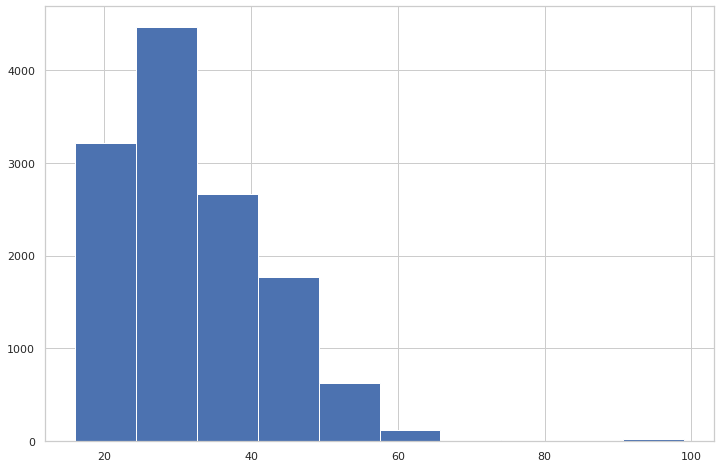

In [17]:
users_full.age.hist()

In [18]:
def change_users_df(df):
    '''Принимает дафрейм, заменяет возраст пользователя, который указал неестественно большой возраст,
       на среднее между мин. значением и макс. значением фильтра поиска данного пользователя
       Также заменяет NaN в колонках coins, was_premium, is_premium на 0'''
    # Работаем с возрастом    
    temp_old = df.query('age > 80')
    temp_df = df.query('age <= 80')
    
    temp_old.age = temp_old[['age_filter_start', 'age_filter_end']].mean(axis=1)
    df_new = pd.concat([temp_old, temp_df])
    
    # Меняем nan на 0
    df_new.fillna({'was_premium': 0, 'is_premium': 0, 'coins': 0}, inplace=True)
    return df_new

In [20]:
# Применим функцию на датафреймы с группами

users_control_1 = change_users_df(users_control_1)
users_control_2 = change_users_df(users_control_2)
users_test = change_users_df(users_test)
users_full = change_users_df(users_full)

Посмотрим на даты проведения эксперимента. Видим, что, судя по совокупным данным даты проведения эксперимента 2017-01-11 - 2017-12-11.

In [21]:
# Узнаем в какой период проводилось тестирование

print( ' Дата первой транзакции в тестовой группе:', transactions_test['paid_at'].min(),'\n', \
       'Дата последней транзакции в тестовой группе:', transactions_test['paid_at'].max())

print( '\n Дата первой транзакции в контр. группе 1:', transactions_control_1['paid_at'].min(),'\n', \
       'Дата последней транзакции в контр. группе 1:', transactions_control_1['paid_at'].max())

print( '\n Дата первой транзакции в контр. группе 2:', transactions_control_2['paid_at'].min(),'\n', \
       'Дата последней транзакции в контр. группе 2:', transactions_control_2['paid_at'].max())

 Дата первой транзакции в тестовой группе: 2017-01-11 04:37:00 
 Дата последней транзакции в тестовой группе: 2017-12-11 22:06:00

 Дата первой транзакции в контр. группе 1: 2016-12-14 16:16:00 
 Дата последней транзакции в контр. группе 1: 2017-12-11 21:57:00

 Дата первой транзакции в контр. группе 2: 2017-01-11 05:34:00 
 Дата последней транзакции в контр. группе 2: 2017-12-11 23:28:00


Но у нас тут затесались лозутчики, с транзакциями в декабре 2016го года. Посмотрим на них. Наш соотечественник заблудился, избавимся от него

In [24]:
transactions_control_1.query('paid_at < "2017-01-11"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,control_1
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,control_1
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,control_1


In [25]:
transactions_control_1 = transactions_control_1.query('uid != 960936960')

Также были обнаружены пользователи с датой покупки, меньшей, чем дата регистрации. Сложный вопрос что это и почему произошло. Возможные варианты: 
* Ошибка в логировании
* Ошибка в выгрузке данных
* Ошибка в логике присвоения айдишников или очистки данных после удаления пользователя с сервиса с последующим переприсваиванием id

Правильного ответа я думаю тут нет, нет возможности установить причину. Оставлю их на месте


In [27]:
transactions_full.query('joined_at >= paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
11,891861048.0,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588.0,68.0,none,premium_no_trial,test
20,891806280.0,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242.0,147.0,trial_vip_popup,trial_premium,test
24,891786216.0,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818.0,147.0,trial_vip_popup,trial_premium,test
25,892057347.0,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209.0,19.0,none,coins,test
36,891589239.0,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305.0,19.0,empty_likes,coins,test
...,...,...,...,...,...,...,...,...,...
305,891606141.0,United States of America,2017-10-31 04:43:00,2017-03-11 21:13:00,3783.0,67.0,empty_likes,other_type,control_2
313,891691062.0,Belgium,2017-10-29 16:19:00,2017-05-11 18:35:00,16614.0,147.0,popular_users_block,trial_premium,control_2
314,892075512.0,United States of America,2017-10-21 16:58:00,2017-08-11 12:18:00,9958.0,147.0,trial_vip_popup,trial_premium,control_2
315,891722802.0,United States of America,2017-10-29 02:08:00,2017-05-11 05:49:00,12727.0,147.0,trial_vip_popup,trial_premium,control_2


### Покрутим данные

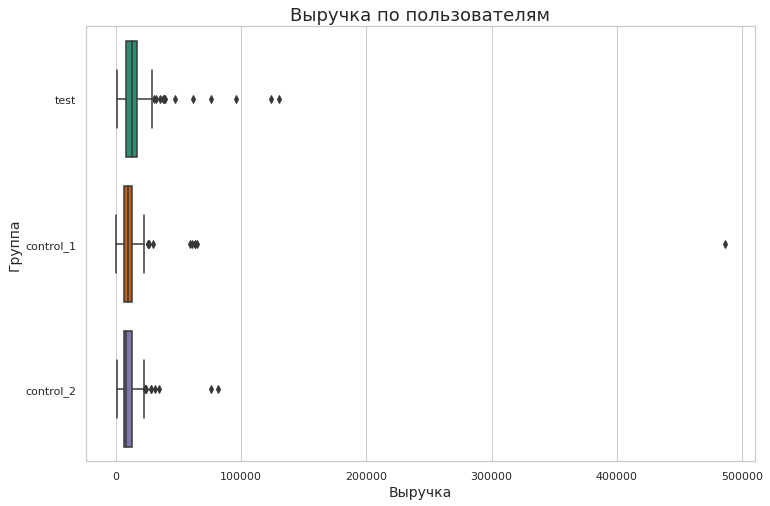

In [26]:
 # Построим боксплоты по выручке
ax = sns.boxplot(data=users_full.query('total_revenue > 0'), x='total_revenue', y='group', palette='Dark2')
ax.axes.set_title("Выручка по пользователям", fontsize=18)
ax.set_xlabel("Выручка", fontsize=14)
ax.set_ylabel("Группа", fontsize=14)
plt.show()